<hr>

I took this note while following [this lecture on Coursera](https://www.coursera.org/learn/tensorflow-tensorrt/home/welcome).

It talks about uing TensorRT to accelerate image classification, using TensorFlow.

I hope it will help you too!

<hr>

In [1]:
import os
import time
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt

import logging, os
logging.disable(logging.WARNING)
logging.getLogger('tensorflow').disabled = True
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.python.saved_model import tag_constants
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

2024-09-01 14:58:35.781538: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-01 14:58:35.781566: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-01 14:58:35.781579: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Introduction

### Fetch Data

We will download some images to process with CNNs. 

In [2]:
!mkdir ./data
!wget  -qO ./data/img0.JPG "https://upload.wikimedia.org/wikipedia/commons/thumb/9/93/Golden_Retriever_Carlos_%2810581910556%29.jpg/640px-Golden_Retriever_Carlos_%2810581910556%29.jpg"
!wget  -qO ./data/img1.JPG "https://upload.wikimedia.org/wikipedia/commons/thumb/6/62/Red-shouldered_Hawk_%28Buteo_lineatus%29_-_Blue_Cypress_Lake%2C_Florida.jpg/407px-Red-shouldered_Hawk_%28Buteo_lineatus%29_-_Blue_Cypress_Lake%2C_Florida.jpg"
!wget  -qO ./data/img2.JPG "https://upload.wikimedia.org/wikipedia/commons/thumb/2/28/Ostrich_male_RWD.jpg/636px-Ostrich_male_RWD.jpg"
!wget  -qO ./data/img3.JPG "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ed/Working_pay_phone%2C_Jensen_Beach%2C_Florida%2C_September_4%2C_2012_001.JPG/360px-Working_pay_phone%2C_Jensen_Beach%2C_Florida%2C_September_4%2C_2012_001.JPG"

mkdir: cannot create directory ‘./data’: File exists


In [3]:
def show_predictions(model):
    for i in range(4):
        img_path = './data/img%d.JPG' % i
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        
        preds = model(x).numpy()
        
        plt.subplot(2,2,i+1)
        plt.imshow(img);
        plt.axis('off');
        label = decode_predictions(preds, top=3)[0][0][1]
        prob = decode_predictions(preds, top=3)[0][0][2]
        plt.title(f"{label}: P={prob * 100:.2f} %")

### Load Pretrained Model

We will use the pre--trained model to process the images

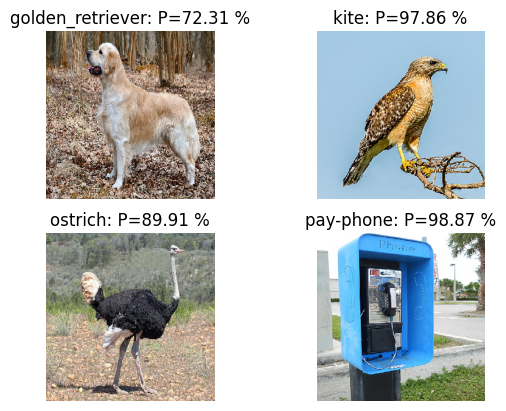

In [4]:
model = InceptionV3(weights="imagenet")
show_predictions(model)

### Save the Model Weight

In [5]:
record = model.export("inceptionv3_saved_model")

Saved artifact at 'inceptionv3_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  Args:
    args_0: float32 Tensor, shape=(None, 299, 299, 3)
  Returns:
    float32 Tensor, shape=(None, 1000)


### Inspect Model Signature

In [6]:
!/home/yushi/.env-tensorflow-2.15.1/bin/saved_model_cli show --all --dir inceptionv3_saved_model | tail -n 50

2024-09-01 14:58:52.292792: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-01 14:58:52.302130: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-01 14:58:52.302147: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
      

## Create Batched Input

In [7]:
def batch_input(batch_size=8):
    X = np.zeros((batch_size, 299, 299, 3), dtype=np.float32)
    for i in range(batch_size):
        img_path = './data/img%d.JPG' % (i % 4)
        img = image.load_img(img_path, target_size=(299, 299))
        X[i] = preprocess_input(image.img_to_array(img))
    return tf.constant(X)

In [8]:
X = batch_input(8)
X.shape

TensorShape([8, 299, 299, 3])

## Load Saved Model

In [9]:
saved_model = tf.saved_model.load("inceptionv3_saved_model", tags=tag_constants.SERVING)
infer = saved_model.signatures['serving_default']

In [10]:
Y = infer(X)
Y.keys()

dict_keys(['output_0'])

In [11]:
decode_predictions(Y['output_0'].numpy(), top=1)

[[('n02099601', 'golden_retriever', 0.72287244)],
 [('n01608432', 'kite', 0.97859335)],
 [('n01518878', 'ostrich', 0.8990876)],
 [('n03902125', 'pay-phone', 0.9886812)],
 [('n02099601', 'golden_retriever', 0.72287244)],
 [('n01608432', 'kite', 0.97859335)],
 [('n01518878', 'ostrich', 0.8990876)],
 [('n03902125', 'pay-phone', 0.9886812)]]

## Get Baseline

In [12]:
def predict_and_benchmark_throughput(
    batched_input, infer, N_warmup_run=50, N_run=1000
):
    elapsed_time = []
    all_preds = []
    batch_size = batched_input.shape[0]
    for i in range(N_warmup_run):
        labeling = infer(batched_input)['output_0']
        preds = labeling.numpy()
    for i in range(N_run):
        start_time = time.time()
        labeling = infer(batched_input)['output_0']
        preds = labeling.numpy()
        end_time = time.time()
        elapsed_time = np.append(elapsed_time, end_time - start_time)
        all_preds.append(preds)
        if i % 200 == 0:
            print(
                'Steps {}-{} average: {:4.1f}ms'.format(
                    i, i+200, (elapsed_time[-200:].mean()) * 1000
                )
            )
    print(
        'Throughput: {:.0f} images/s'.format(
            N_run * batch_size / elapsed_time.sum()
        )
    )
    return all_preds

In [13]:
pred = predict_and_benchmark_throughput(X, infer)

Steps 0-200 average: 13.5ms
Steps 200-400 average: 13.7ms
Steps 400-600 average: 13.5ms
Steps 600-800 average: 13.6ms
Steps 800-1000 average: 13.5ms
Throughput: 590 images/s


## Convert TensorRT Graph

### Overview

- Tensorflow inference: `trained model -> inference`
- TRT inference: `model -> tf-trt optimization -> inference`

Check [the tensorflow documentation](https://www.tensorflow.org/api_docs/python/tf/experimental/tensorrt/Converter) for more details.

### Converting API

```python
converter = tf.experimental.tensorrt.Converter(
    input_saved_model_dir=None,
    input_saved_model_tags=None,
    input_saved_model_signature_key=None,
    use_dynamic_shape=None,
    dynamic_shape_profile_strategy=None,
    max_workspace_size_bytes=DEFAULT_TRT_MAX_WORKSPACE_SIZE_BYTES,
    precision_mode=TrtPrecisionMode.FP32,
    minimum_segment_size=3,
    maximum_cached_engines=1,
    use_calibration=True,
    allow_build_at_runtime=True,
    conversion_params=None
)

converter.convert(calibration_input_fn=None)
```

#### Converter Initialization

- `minimum_segment_size`: the minimum number of nodes required for a subgraph to be replaced by `TRTEngineOp`.
- `maximum_cached_engines`: max number of cached TRT engines for dynamic TRT ops. Created TRT engines for a dynamic dimension are cached. If the number of cached engines is already at max but none of them supports the input shapes, the TRTEngineOp will fall back to run the original TF subgraph that corresponds to the TRTEngineOp.
- `use_calibration`: this argument is ignored if precision_mode is not INT8. If set to True, a calibration graph will be created to calibrate the missing ranges. The calibration graph must be converted to an inference graph by running calibration with calibrate(). If set to False, quantization nodes will be expected for every tensor in the graph (excluding those which will be fused). If a range is missing, an error will occur. Please note that accuracy may be negatively affected if there is a mismatch between which tensors TRT quantizes and which tensors were trained with fake quantization.
- `allow_build_at_runtime`: whether to allow building TensorRT engines during runtime if no prebuilt TensorRT engine can be found that can handle the given inputs during runtime, then a new TensorRT engine is built at runtime if allow_build_at_runtime=True, and otherwise native TF is used.
- `conversion_params`: a TrtConversionParams instance (deprecated).

#### Convert

`calibration_input_fn`: a generator function that yields input data as a `list` or `tuple` or `dict`, which will be used to execute the converted signature for calibration. 

All the returned input data should have the same shape. Example: 

```python
def input_fn():
    yield input1, input2, input3
```

- If `dynamic_shape_mode==False`, (or if the graph has static input shapes) then we run calibration and build the calibrated engine during conversion.
- If `dynamic_shape_mode==True` (and the graph has any unknown input shape), then the reference to `calibration_input_fn` is stored, and the calibration is actually performed when we build the engine (see build()).

### Graph Conversion Parameters - FP16

In [14]:
converter = tf.experimental.tensorrt.Converter(
    input_saved_model_dir="inceptionv3_saved_model",
    input_saved_model_tags=None,
    input_saved_model_signature_key=None,
    use_dynamic_shape=False,
    dynamic_shape_profile_strategy=None,
    precision_mode="FP16",
    minimum_segment_size=3,
    maximum_cached_engines=1,
    use_calibration=True,
    allow_build_at_runtime=True,
    conversion_params=None
)
converter.convert()
converter.save("inceptionv3_saved_trt")

In [15]:
converter.summary()

TRTEngineOP Name                 Device        # Nodes # Inputs      # Outputs     Input DTypes       Output Dtypes      Input Shapes       Output Shapes     
TRTEngineOp_000_000              device:GPU:0  701     1             1             ['float32']        ['float32']        [[-1, 299, 299 ... [[-1, 1000]]      

	- AvgPool: 9x
	- BiasAdd: 1x
	- ConcatV2: 11x
	- Const: 391x
	- Conv2D: 94x
	- FusedBatchNormV3: 94x
	- MatMul: 1x
	- MaxPool: 4x
	- Mean: 1x
	- Relu: 94x
	- Softmax: 1x

[*] Total number of TensorRT engines: 1
[*] % of OPs Converted: 99.72% [701/703]



### TRT performance

In [16]:
infer_trt = tf.saved_model.load("inceptionv3_saved_trt")
func = infer_trt.signatures['serving_default']
output = func(X)

In [17]:
def predict_and_benchmark_throughput_trt(
    batched_input, infer, N_warmup_run=50, N_run=1000
):
    elapsed_time = []
    all_preds = []
    batch_size = batched_input.shape[0]
    for i in range(N_warmup_run):
        labeling = infer(batched_input)['output_0']
        preds = labeling.numpy()
    for i in range(N_run):
        start_time = time.time()
        labeling = infer(batched_input)['output_0']
        preds = labeling.numpy()
        end_time = time.time()
        elapsed_time = np.append(elapsed_time, end_time - start_time)
        all_preds.append(preds)
        if i % 200 == 0:
            print(
                'Steps {}-{} average: {:4.1f}ms'.format(
                    i, i+200, (elapsed_time[-200:].mean()) * 1000
                )
            )
    print(
        'Throughput: {:.0f} images/s'.format(
            N_run * batch_size / elapsed_time.sum()
        )
    )
    return all_preds

pred_trt = predict_and_benchmark_throughput_trt(X, func)

Steps 0-200 average:  3.8ms
Steps 200-400 average:  3.8ms
Steps 400-600 average:  4.3ms
Steps 600-800 average:  3.8ms
Steps 800-1000 average:  3.9ms
Throughput: 2027 images/s


In [18]:
def my_input_fn():
    for i in range(4):
        img_path = './data/img%d.JPG' % i
        img = image.load_img(img_path, target_size=(299, 299))
        x = np.expand_dims(img, 0).astype(np.float32)
        yield x

In [19]:
converter.build(my_input_fn)
converter.save("inceptionv3_saved_trt")

### Graph Conversion Parameters - INT8


Typically, model training is performed using 32-bit floating point mathematics. Due to the backpropagation algorithm and weights updates, this high precision is necessary to allow for model convergence. Once trained, inference could be done in reduced precision (e.g. FP16) as the neural network architecture only requires a feed-forward network.

Reducing numerical precision allows for a smaller model with faster inferencing time, lower memory requirements, and more throughput.

Furthermore, recent NVIDIA GPUs are capable of executing 8-bit integer 4-element vector dot product instructions to accelerate deep neural network inference.


[Source](https://developer.nvidia.com/blog/int8-inference-autonomous-vehicles-tensorrt/): Fast INT8 Inference for Autonomous Vehicles with TensorRT 3

<div align="center">
    <img src='https://developer.nvidia.com/blog/wp-content/uploads/2017/12/dp4a-updated.png' />
    <p style="text-align: center;color:gray"> Figure (d). The DP4A instruction: 4-element dot product with accumulation.</p>
</div>

You might be wondering how it is possible to take a model which operates in 32 bit floating point precision, where you can represent billions of different numbers, and reduce that to only 8 bit integers which can only represent 256 possible values.

The main reason is that, typically in deep learning, the values of weights and activations lie in very small ranges. So if we design our precious 8 bits to only represent this specific small range, we can usually maintain good accuracy while reducing the rounding error.

The main challenge is to find the correct dynamic range of the inputs. TF-TRT uses a calibration process that minimizes the information loss when approximating the FP32 network with a limited 8-bit integer representation. In the next Task, you will see how to perform this calibration process.

Further quantization details: [https://developer.nvidia.com/gtc/2019/video/S9431/video](https://developer.nvidia.com/gtc/2019/video/S9431/video)

In [20]:
def my_calibration_input_fn():
    for i in range(4):
        img_path = './data/img%d.JPG' % i
        img = image.load_img(img_path, target_size=(299, 299))
        x = np.expand_dims(img, 0).astype(np.float32)
        yield x

converter = tf.experimental.tensorrt.Converter(
    input_saved_model_dir="inceptionv3_saved_model",
    input_saved_model_tags=None,
    input_saved_model_signature_key=None,
    use_dynamic_shape=False,
    dynamic_shape_profile_strategy=None,
    precision_mode="INT8",
    minimum_segment_size=3,
    maximum_cached_engines=1,
    use_calibration=True,
    allow_build_at_runtime=True,
    conversion_params=None
)
converter.convert(calibration_input_fn=my_calibration_input_fn)
converter.save("inceptionv3_saved_trt_int8")

In [21]:
infer_trt = tf.saved_model.load("inceptionv3_saved_trt_int8")
func = infer_trt.signatures['serving_default']
output = func(X)

In [22]:
pred_trt = predict_and_benchmark_throughput_trt(X, func)

Steps 0-200 average:  3.1ms
Steps 200-400 average:  3.1ms
Steps 400-600 average:  3.0ms
Steps 600-800 average:  3.1ms
Steps 800-1000 average:  3.0ms
Throughput: 2597 images/s


In [23]:
converter.build(my_input_fn)
converter.save("inceptionv3_saved_trt_int8")